In [14]:
import pandas as pd
import numpy as np
from datetime import time, timedelta
import math

class Node():
    # Initializes a Node with time, airport, and default values for links, profit, and time elapsed
    def __init__(self, Time, airport):
        self.Time = Time
        self.Airport = airport
        self.inLink = None
        self.outLink = None
        self.Tot_profit = None
        self.Time_elapsed = time(0,0)

    # Adds an incoming link to the node
    def add_inLink(self, link):
        self.inLink = link

    # Adds an outgoing link to the node
    def add_outLink(self, link):
        self.outLink = link

    # Calculates total profit at this node
    def add_Profit(self):
        self.Tot_profit = self.outLink.Profit + self.outLink.To.Tot_profit

    # Updates the time elapsed for this node
    def add_Time(self, onground=False):
        if onground is True:
          self.Time_elapsed = add_time(self.outLink.To.Time_elapsed, 0, 6)
        else:
          self.Time_elapsed = add_time(self.outLink.Flighttime, self.outLink.To.Time_elapsed.hour, self.outLink.To.Time_elapsed.minute)

    # String representation of the node
    def __str__(self):
        return f'Node at time: {self.Time} and airport: {self.Airport}'

    # Representation used for debugging
    def __repr__(self):
        return f'{self.Time}_{self.Airport}_{round(self.Tot_profit)}'

class Link():
    # Initializes a Link with origin, destination, distance, cost, revenue, profit, pax, and flighttime
    def __init__(self, origin, destination, distance, cost, revenue, profit, pax, flighttime):
        self.From = origin
        self.To = destination
        self.Distance = distance
        self.cost = cost
        self.revenue = revenue
        self.Profit = profit
        self.Pax = pax
        self.Flighttime = flighttime


In [4]:
## Mount drive to access files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
## Load data, create demand dictionary and define functions for later use
global df_aircraft, df_airports, df_demand, df_distances, df_coefficients
df_aircraft = pd.read_excel('/content/drive/MyDrive/AE4423-20 Airline Planning/Problem 3/Aircraft_fleet_info.xlsx', index_col=0)
df_aircraft = df_aircraft.transpose() # Type names is index column
df_airports = pd.read_csv('/content/drive/MyDrive//AE4423-20 Airline Planning/Problem 3/Group_30Regional_Airport_info.csv', index_col=1) # ICAO code is index column
df_demand = pd.read_csv('/content/drive/MyDrive//AE4423-20 Airline Planning/Problem 3/Group_30Regional_Demand.csv', index_col=0) # ICAO code is index column and header row
df_distances = pd.read_csv('/content/drive/MyDrive//AE4423-20 Airline Planning/Problem 3/Group_30Regional_Distances.csv', index_col=0) # ICAO code is index column and header row
df_coefficients = pd.read_csv('/content/drive/MyDrive//AE4423-20 Airline Planning/Problem 3/Group_30Hourly_Coefficients.csv', index_col=3) # ICAO code is index column
aircraft_names = {1: 'Type 1: Regional turboprop', 2: 'Type 2: Electric regional aircraft', 3: 'Type 3: Electric regional aircraft'}

# Fixed parameters
f = 1.42 # Price of fuel
e = 0.07 # Price of energy


# Function to add hours and minutes to a given time)
def add_time(time_current, hours, minutes=0):
    hours1 = time_current.hour
    minutes1 = time_current.minute

    minutes2 = minutes1 + minutes
    tot_hours = (hours1 + minutes2 // 60 + hours) % 24

    minutes3 = minutes2 % 60

    return time(tot_hours, minutes3)

# Function to calculate yield based on distance
def calc_yld(distance):
    return 5.9 * distance ** -0.76 + 0.043

# Function to calculate cost for a flight leg
def calc_cost(k, i, j):
    CX = df_aircraft.loc[k, 'Fixed Operating Cost (Per Fligth Leg)  [€]']  # Fixed operating cost
    CT = df_aircraft.loc[k, 'Cost per Hour'] * df_distances.loc[i, j] / df_aircraft.loc[k, 'Speed [km/h]']  # Time-based costs
    CF = df_aircraft.loc[k, 'Fuel Cost Parameter'] * f / 1.5 * df_distances.loc[i, j]  # Fuel costs
    CE = e * df_aircraft.loc[k, 'Batteries energy (kWh)'] * df_distances.loc[i, j] / df_aircraft.loc[k, 'Maximum Range [km]']

    COST = CX + CT
    if k == 'Type 1: Regional turboprop':
        COST = COST + CF
        if i == 'LIME' or j == 'LIME': # Flights to or from hub have 30% lower costs
          COST = 0.7 * COST
    else:
        if i == 'LIME' or j == 'LIME': # Flights to or from hub have 30% lower costs
          COST = 0.7 * COST
        COST = COST + CE

    return COST

# Function to calculate demand based on timestamp and airports
def calc_demand(timestamp, i , j): # TODO: remove demand after assigning a flight, not sure whether to do this immediately in this function
    time_current = int(timestamp.hour)
    time_plus1 = int(add_time(timestamp, 1).hour)
    time_minus1 = int(add_time(timestamp, -1).hour)
    time_minus2 = int(add_time(timestamp, -2).hour)
    demand = demand_dict[i][j][time_current] + demand_dict[i][j][time_plus1] + demand_dict[i][j][time_minus1] + demand_dict[i][j][time_minus2]
    demand = math.floor(demand)
    return demand

# Function to calculate flight time based on distance and aircraft type
def calc_flight_time(distance, aircraft_type):
    tat_time = df_aircraft.loc[aircraft_names[aircraft_type], 'Average TAT [min]']
    take_off_landing_time = 30
    cruise_time = (distance / df_aircraft.loc[aircraft_names[aircraft_type], 'Speed [km/h]'])*60
    if aircraft_type != 1:
        charging_time = int(df_aircraft.loc[aircraft_names[aircraft_type], 'Additional charging time'])
    else:
      charging_time = 0
    total_time = tat_time + take_off_landing_time + cruise_time + charging_time
    hours = int(total_time // 60)
    minutes = total_time % 60


    rest_minutes = 6 - minutes % 6
    total_minutes = int(math.ceil(minutes + rest_minutes))
    if total_minutes == 60:
        flight_time = time(hours+1, 0)
    else:
        flight_time = time(hours, total_minutes)


    return flight_time #CHECK THISSSSSSS!!!!!!!!!!!!!!!!!!!! FOR ROUNDING

# Function to calculate various flight parameters
def calc_flight_params(timestamp, origin, destination, aircraft_type):

  distance = df_distances.loc[origin, destination]
  flight_time = calc_flight_time(distance, aircraft_type)
  demand = calc_demand(timestamp, origin, destination)
  seats = df_aircraft.loc[aircraft_names[aircraft_type], 'Seats']
  pax = min(demand, seats)
  yld = calc_yld(distance)
  revenue = yld * distance * pax
  cost = calc_cost(aircraft_names[aircraft_type], origin, destination)
  profit = revenue - cost
  arrival_time = add_time(timestamp, flight_time.hour, flight_time.minute)
  total_profit = profit

  return cost, revenue, profit, pax, distance, arrival_time, flight_time

# Function to check if the flight is feasible based on aircraft type, origin, destination, and distance
def calc_airportcheck(aircraft_type, origin, destination, distance):
  check = True
  maxrange = df_aircraft.loc[aircraft_names[aircraft_type], 'Maximum Range [km]']
  minrunway = df_aircraft.loc[aircraft_names[aircraft_type], 'Runway Required [m]']

  if maxrange < distance:
    check = False
  if minrunway > df_airports.loc[destination, 'Runway (m)'] or minrunway > df_airports.loc[origin, 'Runway (m)']:
    check = False

  return check

# Function to update demand after assigning a flight
def calc_delete_demand(demand_dict, route_selected):

  for flight in route_selected.index:
    timestamp = route_selected['Departure Time'][flight]
    origin = route_selected['Route'][flight][:4]
    destination = route_selected['Route'][flight][-4:]
    pax = route_selected['Passengers'][flight]

    time_current = int(timestamp.hour)
    time_plus1 = int(add_time(timestamp, 1).hour)
    time_minus1 = int(add_time(timestamp, -1).hour)
    time_minus2 = int(add_time(timestamp, -2).hour)
    dem_current = demand_dict[origin][destination][time_current]
    dem_plus1 = demand_dict[origin][destination][time_plus1]
    dem_minus1 = demand_dict[origin][destination][time_minus1]
    dem_minus2 = demand_dict[origin][destination][time_minus2]

    # Check current timestep
    if pax > dem_current:
      demand_dict[origin][destination][time_current] = 0
      pax -= dem_current
    else:
      demand_dict[origin][destination][time_current] -= pax


    # If still passengers left, check minus 1
    if pax > 0 and pax > dem_minus1:
      demand_dict[origin][destination][time_minus1] = 0
      pax -= dem_minus1
    else:
      demand_dict[origin][destination][time_minus1] -= pax
      pax = 0

    # If still passengers left, check plus 1
    if pax > 0 and pax > dem_plus1:
      demand_dict[origin][destination][time_plus1] = 0
      pax -= dem_plus1
    else:
      demand_dict[origin][destination][time_plus1] -= pax
      pax = 0

    # If still passengers left, check minus 2
    if pax > 0 and pax > dem_minus2:
      demand_dict[origin][destination][time_minus2] = 0
      pax -= dem_minus2
    else:
      demand_dict[origin][destination][time_minus2] -= pax
      pax = 0
  return demand_dict

In [16]:
# Demand percentages and lease costs setup
demand_percentages = [1.0]
#demand_percentages = [0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4] # Uncomment when doing sensitivity analysis for demand
lease_costs = {1: 2143, 2: 3142, 3: 1714}
profit_dict = {}
aircraft_usage_dict = {}


for demand in demand_percentages:
  # Create demand dictionary
  demand_dict = {}
  for airport1 in df_airports.index:
    demand_dict[airport1] = {}
    for airport2 in df_airports.index:
      demand_dict[airport1][airport2] = {}
      for timestep in range(0,24):
        demand_dict[airport1][airport2][timestep] = round(df_demand.loc[airport1, airport2] * df_coefficients.loc[airport1, str(timestep)]*demand, 0)

  ## Big loop with dynamic programming inner loop

  total_aircraft = {1: 5, 2:3, 3:3}
  selected_aircraft_dict = {1: 0, 2: 0, 3:0}
  total_profit_aircraft = 0
  routes_selected = {}

  route_index = 1
  while sum(total_aircraft.values()) != 0:
    profits = {}
    routes = {}
    for aircraft in [1,2,3]:
      if total_aircraft[aircraft] <= 0:
        profits[aircraft] = 0
        continue
      aircraft_type = aircraft

      # Dynamic programming inner loop starts here
      start_node = Node(time(0, 0), 'LIME')
      end_node = Node(time(23, 54), 'LIME')

      lst_time = [time(i, j*6) for i in range(23, -1, -1) for j in range(9, -1, -1)]
      lst_airports = list(df_airports.index)

      nodes_dict = {}

      for timestamp in lst_time:
          if timestamp == end_node.Time:
              end_node.Tot_profit = 0
              end_node.Time_elapsed = time(0,0)
              end_node.add_outLink('dummy')
              nodes_dict[timestamp] = {i: None for i in df_airports.index}
              nodes_dict[timestamp]['LIME'] = end_node

          else:
              current_nodes = {i: None for i in df_airports.index}
              prev_nodes = nodes_dict[add_time(timestamp, 0, 6)]

              for airport in lst_airports:
                # print(airport)
                # print(timestamp, lst_airports)
                if airport == 'LIME':
                    # print(timestamp, airport)
                    best_profit = prev_nodes['LIME'].Tot_profit
                    best_airport = 'LIME'

                    for airport_to in lst_airports:
                      if airport_to != 'LIME':
                          destination = airport_to
                          origin = 'LIME'
                          cost, revenue, profit, pax, distance, arrival_time, flight_time = calc_flight_params(timestamp, origin, destination, aircraft_type)

                          # print(arrival_time)
                          airportcheck = calc_airportcheck(aircraft_type, origin, destination, distance)
                          if arrival_time > timestamp and airportcheck == True and nodes_dict[arrival_time][airport_to] != None: #Moeten we dit eigenlijk wel checken als je van hub naar airport gaat?
                            if add_time(flight_time, nodes_dict[arrival_time][airport_to].Time_elapsed.hour, nodes_dict[arrival_time][airport_to].Time_elapsed.minute)  <= time(18,0):
                              total_profit = profit + nodes_dict[arrival_time][airport_to].Tot_profit

                              if total_profit > best_profit:
                                  best_profit = total_profit
                                  best_airport = airport_to

                            else:
                              # print('triggered:',timestamp, best_airport
                              pass


                    # print(timestamp, best_airport)
                    if best_airport == 'LIME':
                      # print('Stay at hub')
                      destination_node = prev_nodes['LIME']
                      new_node = Node(timestamp, 'LIME')
                      new_link = Link(new_node, destination_node, 0, 0, 0, 0, 0, time(0,0))
                      new_node.add_outLink(new_link)
                      new_node.add_Profit()
                      # print(new_node.Time_elapsed)
                      if destination_node.Time_elapsed != time(0,0): # Because 'last' ground arc should not be added to total time
                        new_node.add_Time(onground=True)
                      current_nodes[airport] = new_node

                    else:
                      cost, revenue, profit, pax, distance, arrival_time, flight_time = calc_flight_params(timestamp, 'LIME', best_airport, aircraft_type)
                      destination_node = nodes_dict[arrival_time][best_airport]
                      new_node = Node(timestamp, 'LIME')
                      new_link = Link(new_node, destination_node, distance, cost, revenue, profit, pax, flight_time)
                      new_node.add_outLink(new_link)
                      new_node.add_Profit()
                      new_node.add_Time()
                      current_nodes[airport] = new_node

                else:
                    destination = 'LIME'
                    origin = airport
                    cost, revenue, profit, pax, distance, arrival_time, flight_time = calc_flight_params(timestamp, origin, destination, aircraft_type)

                    airportcheck = calc_airportcheck(aircraft_type, origin, destination, distance)
                    if arrival_time > timestamp and airportcheck == True and (prev_nodes[airport] is None or profit + nodes_dict[arrival_time][destination].Tot_profit > prev_nodes[airport].Tot_profit): #Always add a flight when there is no profit recorded yet
                        if add_time(flight_time, nodes_dict[arrival_time][destination].Time_elapsed.hour, nodes_dict[arrival_time][destination].Time_elapsed.minute)  <= time(18,0):
                          destination_node = nodes_dict[arrival_time][destination]
                          new_node = Node(timestamp, airport)
                          # print(flighttime)
                          new_link = Link(new_node, destination_node, distance, cost, revenue, profit, pax, flight_time)
                          new_node.add_outLink(new_link)
                          new_node.add_Profit()
                          # print(new_link.Flighttime)
                          # print(new_link.To.Time_elapsed)
                          new_node.add_Time()
                          # print(new_node.Time_elapsed)
                          current_nodes[airport] = new_node

                    elif prev_nodes[airport] is not None:
                        destination_node = prev_nodes[airport]
                        new_node = Node(timestamp, airport)
                        new_link = Link(new_node, destination_node, 0, 0, 0, 0, 0, time(0, 0))
                        new_node.add_outLink(new_link)
                        new_node.add_Profit()
                        new_node.add_Time(onground=True)
                        current_nodes[airport] = new_node



              nodes_dict[timestamp] = current_nodes

              # print(current_nodes)

      # Dynamic programming inner loop starts here

      node = nodes_dict[timestamp]['LIME']
      profits[aircraft] = node.Tot_profit

      d = {'Departure Time': [], 'Route': [], 'Arrival Time': [], 'Passengers': [], 'Load-factor': [], 'Cost': [], 'Revenue': [], 'Profit': [], 'Operating time': []}

      planner = pd.DataFrame(d)

      while node != end_node:

        nextnode = node.outLink.To
        if nextnode.Airport != node.Airport:
          departure = node.Time
          route = f'{node.Airport} - {nextnode.Airport}'
          arrival = nextnode.Time
          passengers = int(node.outLink.Pax)
          loadfactor = passengers / df_aircraft.loc[aircraft_names[aircraft_type], 'Seats']
          cost = node.outLink.cost
          revenue = node.outLink.revenue
          profit = node.outLink.Profit
          operatingtime = node.Time_elapsed

          planner.loc[len(planner.index)] = [departure, route, arrival, passengers, loadfactor, cost, revenue, profit, operatingtime]

        node = nextnode

      planner["Operating time"] = planner["Operating time"].values[::-1]

      routes[aircraft] = planner

    print(profits)
    ac_selected = max(profits, key=profits.get)
    print('Selected aircraft is type', ac_selected)
    profit = profits[ac_selected] - lease_costs[ac_selected]
    print(f'With profit of €{round(profit, 2)}')

    if profit < 0 or profits[1] <= 0 and profits[2] <= 0 and profits[3] <= 0:
      print('No more profitable routes possible')
      break

    total_profit_aircraft += profit
    total_aircraft[ac_selected] -= 1
    selected_aircraft_dict[ac_selected] += 1
    print('Aircraft left:', total_aircraft)
    # Demand eruit halen
    route_selected = routes[ac_selected]
    # print(demand_dict)
    # print(route_selected)
    demand_dict = calc_delete_demand(demand_dict, route_selected)
    # print(demand_dict)

    routes_selected[f'{ac_selected}.{route_index}'] = [profit, route_selected]

    route_index += 1
  profit_dict[demand] = total_profit_aircraft
  aircraft_usage_dict[demand] = selected_aircraft_dict


{1: 10926.064545721076, 2: 8775.171590867265, 3: 2309.580249626928}
Selected aircraft is type 1
With profit of €8783.06
Aircraft left: {1: 4, 2: 3, 3: 3}
{1: 10915.443059947325, 2: 8775.171590867265, 3: 2309.580249626928}
Selected aircraft is type 1
With profit of €8772.44
Aircraft left: {1: 3, 2: 3, 3: 3}
{1: 10883.243187722745, 2: 8775.171590867265, 3: 2309.580249626928}
Selected aircraft is type 1
With profit of €8740.24
Aircraft left: {1: 2, 2: 3, 3: 3}
{1: 10797.94455662087, 2: 8775.171590867265, 3: 2309.580249626928}
Selected aircraft is type 1
With profit of €8654.94
Aircraft left: {1: 1, 2: 3, 3: 3}
{1: 10785.949447277406, 2: 8732.832796692079, 3: 2309.580249626928}
Selected aircraft is type 1
With profit of €8642.95
Aircraft left: {1: 0, 2: 3, 3: 3}
{1: 0, 2: 8732.832796692079, 3: 2309.580249626928}
Selected aircraft is type 2
With profit of €5590.83
Aircraft left: {1: 0, 2: 2, 3: 3}
{1: 0, 2: 8629.578393342917, 3: 2309.580249626928}
Selected aircraft is type 2
With profit of 

In [17]:
## Analysis of routes flown
dict_spokes = {}
for airport in df_airports.index[1:]:
  flights = 0
  for name, route in routes_selected.items():
    try:
      flights += route[1]['Route'].value_counts()[f'LIME - {airport}']
    except:
      KeyError
  dict_spokes[airport] = flights

print(dict_spokes.values())

dict_values([4, 13, 0, 0, 1, 13, 19, 3, 3, 0, 4])


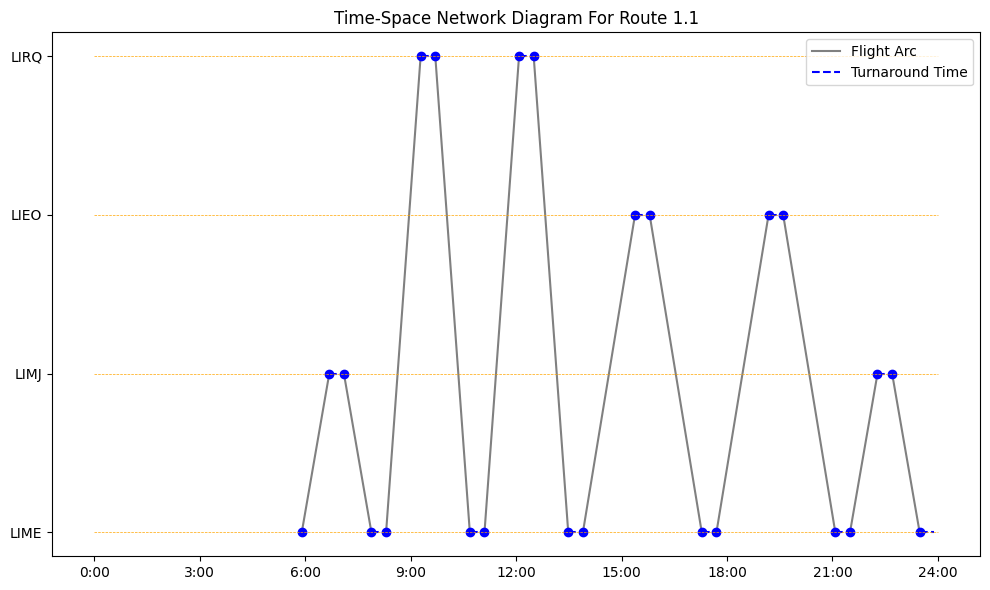

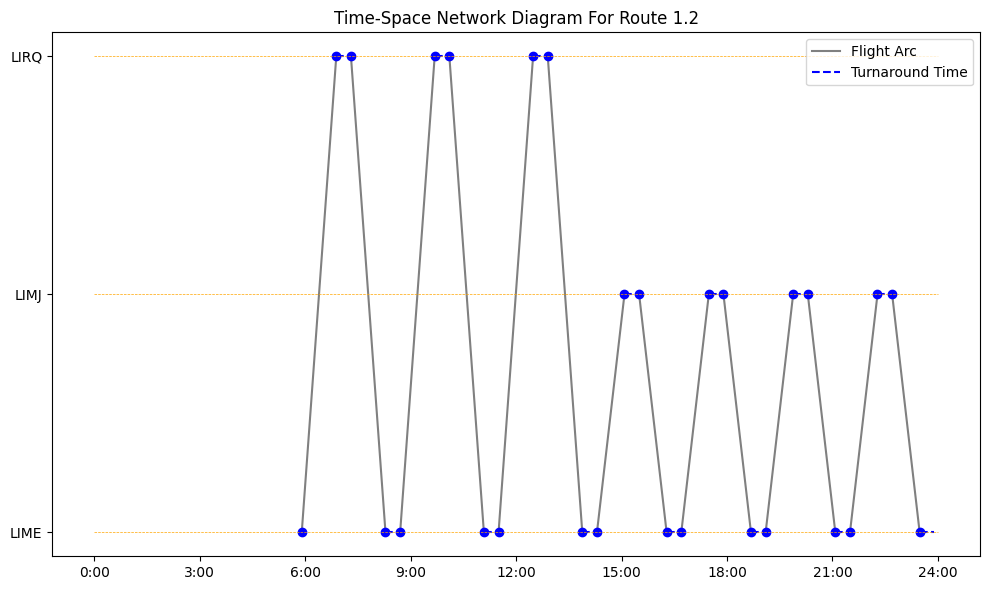

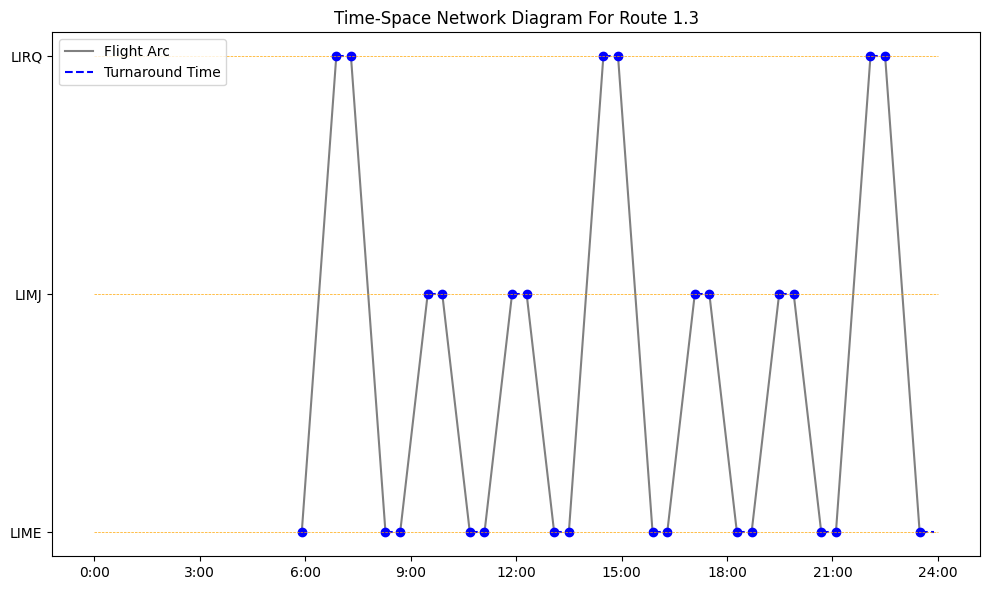

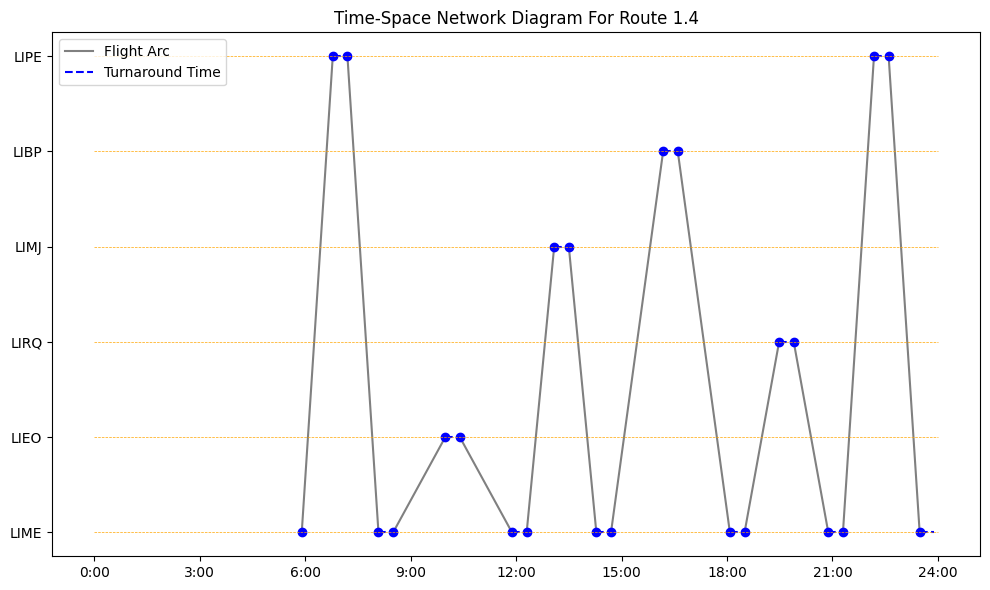

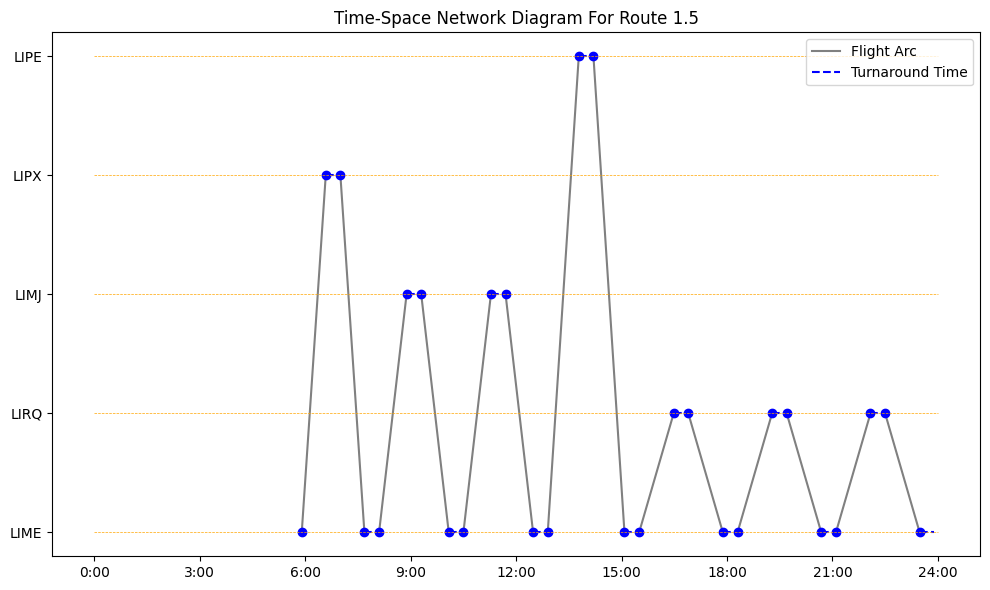

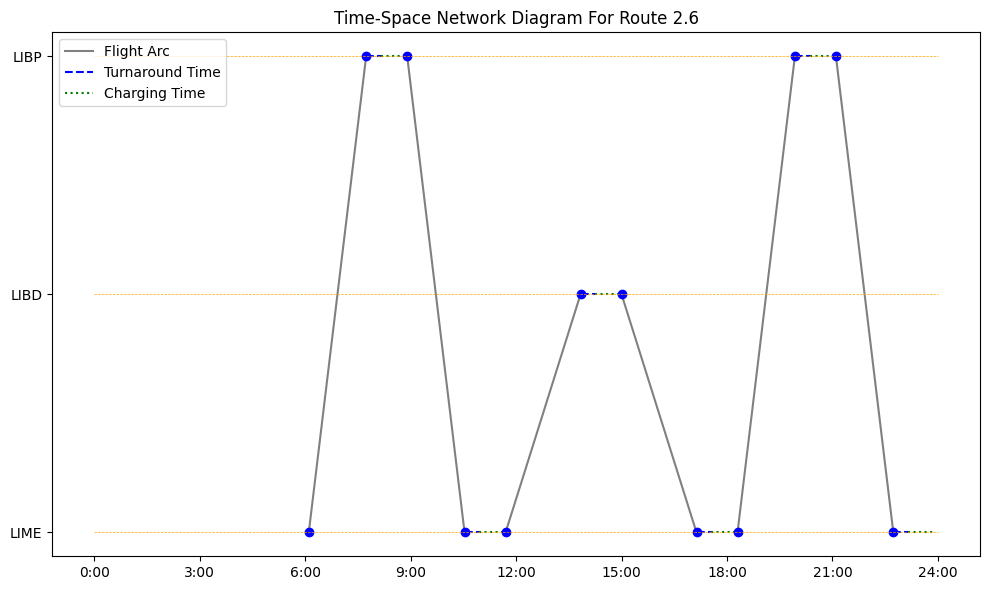

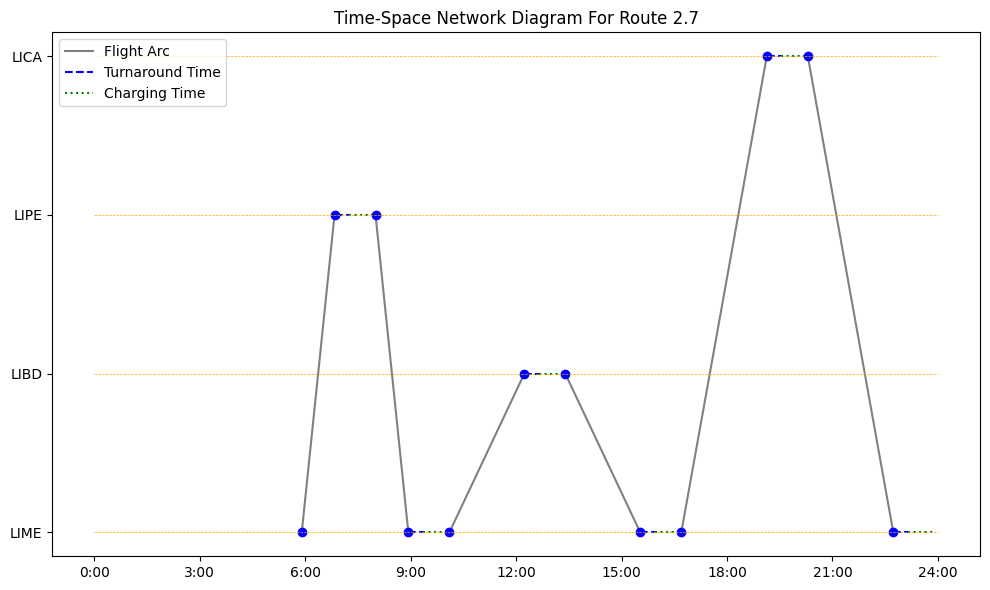

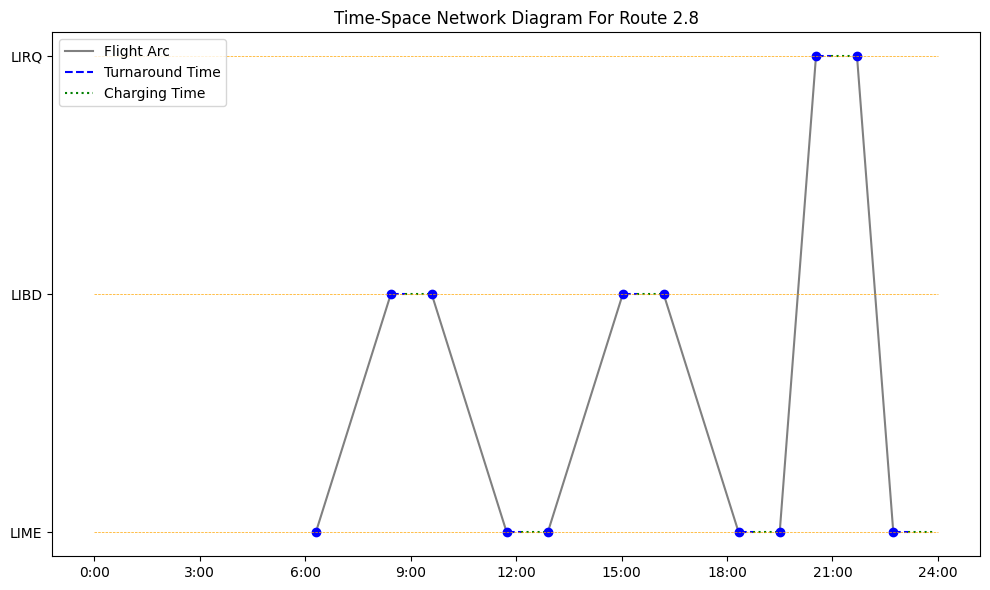

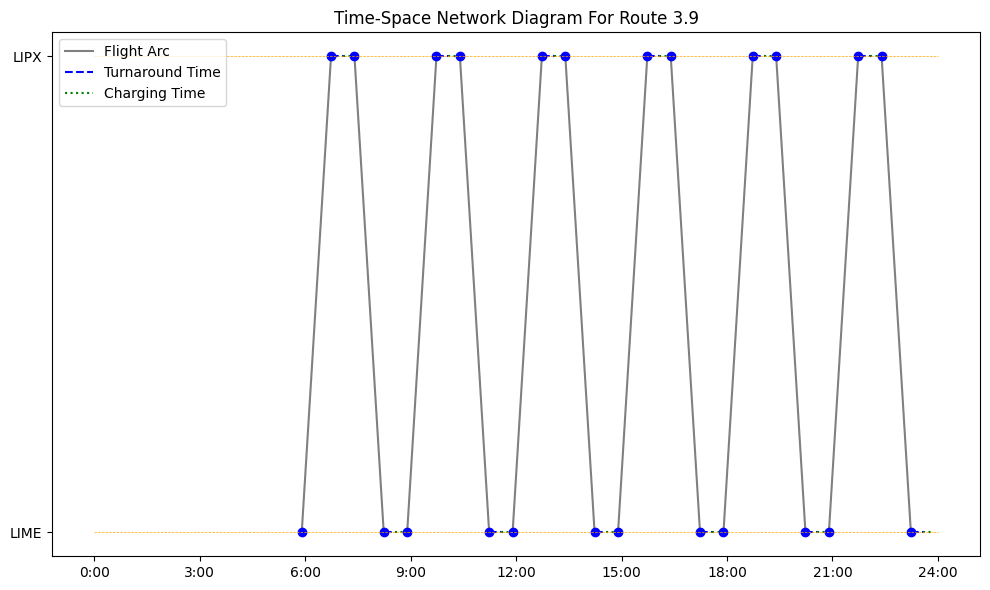

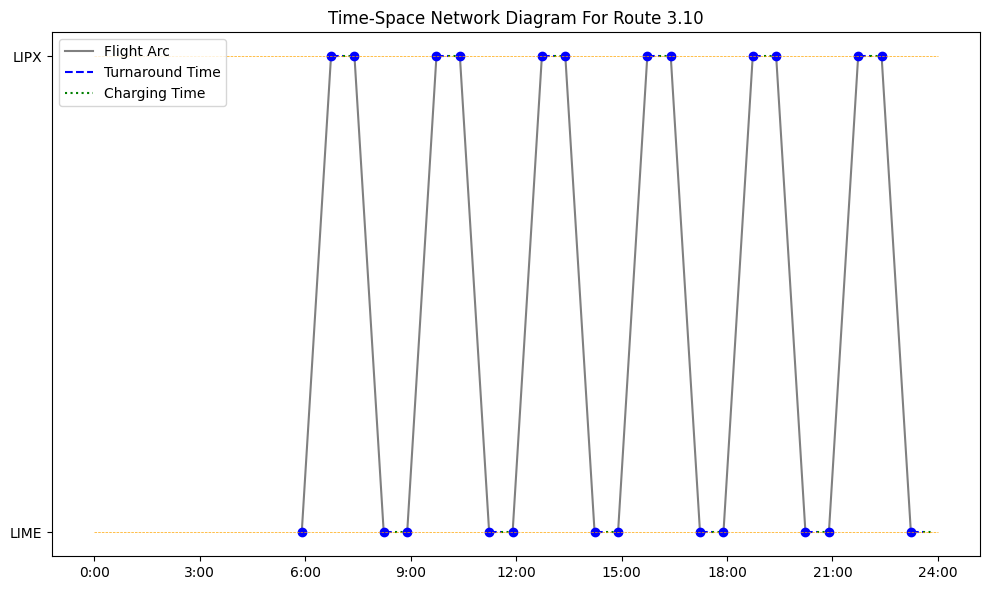

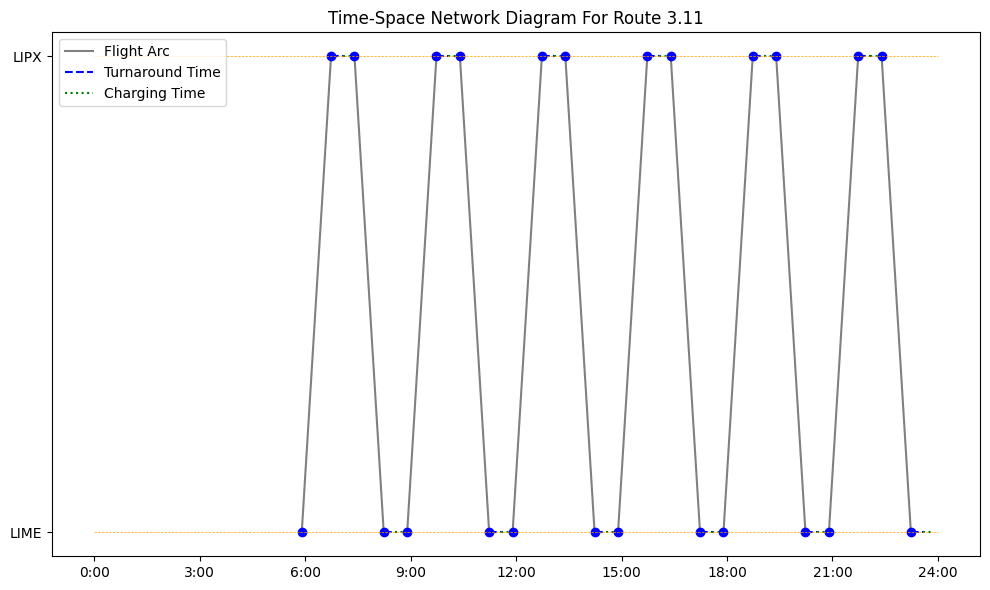

In [18]:
## Plotting of time-space diagrams

def plot_time_space_individual(routes_selected, aircraft_tat, aircraft_charging):
    import matplotlib.pyplot as plt
    import numpy as np
    from datetime import time

    def convert_to_fraction_of_day(t):
        return (t.hour + t.minute / 60) / 24

    for route_key in routes_selected.keys():
        aircraft_type = int(route_key.split('.')[0])

        airports = []
        flights = []

        route_data = routes_selected[route_key][1]
        for index, row in route_data.iterrows():
            departure = row['Departure Time']
            arrival = row['Arrival Time']
            from_airport, to_airport = row['Route'].split(' - ')
            flights.append((departure, arrival, from_airport, to_airport))
            airports.append(from_airport)
            airports.append(to_airport)

        airports = list(set(airports))
        if 'LIME' in airports:
            airports.remove('LIME')
            airports.insert(0, 'LIME')
        airports_dict = {airport: idx for idx, airport in enumerate(airports)}

        fig, ax = plt.subplots(figsize=(10, 6))

        for i, (start_time, end_time, start_node, end_node) in enumerate(flights):
            start_pos = convert_to_fraction_of_day(start_time)
            end_pos_original = convert_to_fraction_of_day(end_time)
            tat = aircraft_tat[aircraft_type] / (24 * 60)
            charging_time = 0
            if aircraft_type in [2, 3]:
                charging_time = aircraft_charging[aircraft_type] / (24 * 60)

            end_pos = end_pos_original - tat - charging_time
            y_start = airports_dict[start_node]
            y_end = airports_dict[end_node]

            ax.plot([start_pos, end_pos], [y_start, y_end], color='grey', label='Flight Arc' if i == 0 else '')
            ax.plot(start_pos, y_start, 'bo')  # Node
            ax.plot(end_pos, y_end, 'bo')     # Node

            # Turnaround time
            ax.plot([end_pos, end_pos + tat], [y_end, y_end], linestyle='--', color='blue', label='Turnaround Time' if i == 0 else '')

            # Charging time for aircraft types 2 and 3
            if aircraft_type in [2, 3]:
                ax.plot([end_pos + tat, end_pos_original], [y_end, y_end], linestyle=':', color='green', label='Charging Time' if i == 0 else '')

        # Drawing dashed lines for each airport's timeline
        for airport, y_pos in airports_dict.items():
            ax.hlines(y_pos, 0, 1, colors='orange', linestyles='dashed', lw=0.5)

        # Setting the x-axis and y-axis labels
        time_labels = [f"{hour}:00" for hour in range(0, 25, 3)]
        ax.set_xticks(np.linspace(0, 1, len(time_labels)))
        ax.set_xticklabels(time_labels)
        ax.set_yticks(list(airports_dict.values()))
        ax.set_yticklabels(list(airports_dict.keys()))

        # Inverting y-axis, removing spines

        # Adding a title and showing the plot
        ax.set_title(f'Time-Space Network Diagram For Route {route_key}')
        plt.legend()
        plt.tight_layout()
        plt.savefig(f'Time_Space_{route_key}.png')
        plt.show()

aircraft_tat = {1: 25, 2: 25, 3: 20}
aircraft_charging = {2: 45, 3: 20}
plot_time_space_individual(routes_selected, aircraft_tat, aircraft_charging)



In [19]:
## Summing relevant columns for analysis
for aircraft, route in routes_selected.items():
  route[1].loc[len(route[1].index)] = ['','', '', route[1]['Passengers'].sum(),route[1]['Load-factor'].sum()/len(route[1]),route[1]['Cost'].sum(),route[1]['Revenue'].sum(),route[1]['Profit'].sum(), '']


In [21]:
## Write to csv files to output routes
for aircraft, route in routes_selected.items():
  route[1].to_csv(f'/content/drive/MyDrive/AE4423-20 Airline Planning/Problem 3/{aircraft}.csv', index=False)

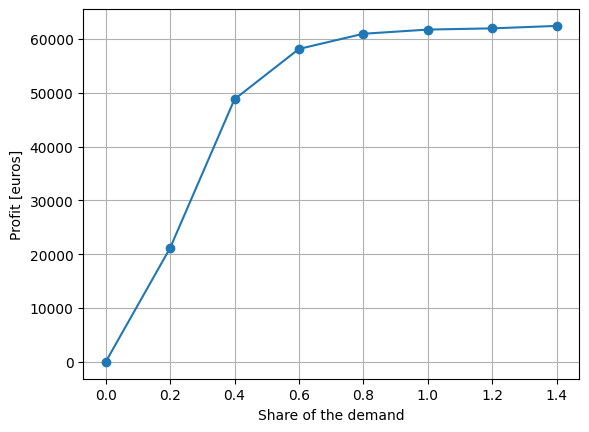

{0: {1: 0, 2: 0, 3: 0}, 0.2: {1: 4, 2: 0, 3: 0}, 0.4: {1: 5, 2: 3, 3: 0}, 0.6: {1: 5, 2: 3, 3: 3}, 0.8: {1: 5, 2: 3, 3: 3}, 1.0: {1: 5, 2: 3, 3: 3}, 1.2: {1: 5, 2: 3, 3: 3}, 1.4: {1: 5, 2: 3, 3: 3}}


In [13]:

import matplotlib.pyplot as plt

# Creating the plot
plt.plot(profit_dict.keys(), profit_dict.values(), marker='o')  # Added a marker for better visibility

# Adding labels and title
plt.xlabel('Share of the demand')  # Replace 'Time Period' with a more specific label if needed
plt.ylabel('Profit [euros]')      # Replace 'Profit' with the appropriate label for your data
 # Replace with a more specific title if needed

# Optionally, you can add a grid for better readability
plt.grid(True)

# Show the plot
plt.show()

print(aircraft_usage_dict)